# Machine Learning Engineer Nanodegree

## Capstone Project

### Using Computer Vision for Facial Expression Classification

This project seeks to investigate the use of computer vision techniques to build a classifier that can classify different faces, based on facial expressions.

A deep learning approach will be taken to this problem, investigating the use of convolutional neural networks (CNNs). 

A simple benchmark CNN will first be investigated, followed by a more complex and deep network.

In addition, the use of pre-trained networks for the ImageNet challenge (link to something here) will be explored to aid performance in the facial expression classification problem. 






In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint  

from keras import losses
from keras import backend as K
from keras import applications
from keras import optimizers

%matplotlib inline

### Reading the Data

The dataset can be obtained from [here](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge). For the purpose of this notebook, and determining the best classification model, only the first 15,000 entries will be used. Later, the entire dataset will be used for training, testing and validation on the optimal model, to gain an idea for the true performance of the model.

Below, Pandas is used to read the input data into a Data Frame

In [12]:
use_section_data = True

if use_section_data:
    data = pd.read_csv("section_fer2013.csv")    
else:
    data = pd.read_csv("fer2013cp.csv")

labels = data['emotion']

features = data.drop(['emotion','Usage'], axis=1, inplace=False)


### Pre-Processing the Data

The raw data is in .csv format, with every pixel value listed in a single cell, for each image, separated by spaces.

Below, each pixel value is separated, to be an individual value in a Python list, within a Data Frame.

In addition, the data will be converted to a tensor format.

In [13]:
temp_list = []

for i in features['pixels']:
    temp_list.append(i.split())
    
features.drop('pixels',axis=1,inplace=True)

features['pixels'] = pd.Series(temp_list)

Of all of the data that has been imported, 20% will be used for training, 10% for validation, and 70% for training.

In [14]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state=0)

In [15]:
def df_to_tensor(X_in, im_dim, reshape=True, triple_channels=False, horizontal_flip_double=False):
    
    # convert from the dataframe which contains Python lists with all pixel values, into a tensor, suitable for
    # input into a convolutional neural network
    
    list_of_2d_arrays = []
    
    
    
    for image in X_in['pixels']:
        pixel_array = []
        
        for pixel in image:
            if not triple_channels:
                pixel_array.append(int(pixel))
            else:
                pixel_array.append([int(pixel),int(pixel),int(pixel)])
        
        pixel_array = [pixel_array[x:x+im_dim] for x in range(0,len(pixel_array),im_dim)]
        
        
        
        list_of_2d_arrays.append(pixel_array)
        
    if horizontal_flip_double == True:
        
        reversed_array = []
        
        for pixel_row in pixel_array:
            reversed_array.append(pixel_row[::-1])
            
        list_of_2d_arrays.append(reversed_array)
            
            
        
        
    np_arr =  np.array(list_of_2d_arrays)
    
    #print(np_arr.shape)
    if reshape:
        return np_arr.reshape(np_arr.shape[0], 48, 48, 1)
    else:
        return np_arr

### Sample Visualization

A few of the images from the dataset will be plotted below.

In [16]:
# take a few sample images to provide a visualization

samples = df_to_tensor(features,48)

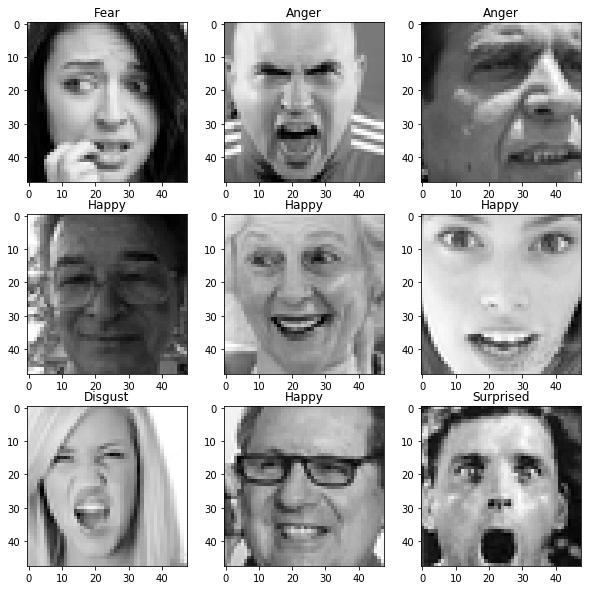

In [17]:
seed_number = 21

two_d_array = samples[seed_number].reshape(48,48)

fig = plt.figure(figsize=(10, 10))

num_rows = 3

num_columns = 3

hardcoded_labels = ["Fear", "Anger", "Anger", "Happy", "Happy",
                   "Happy", "Disgust", "Happy", "Surprised"]

for i in range(num_rows*num_columns):
    ax = fig.add_subplot(num_rows,num_columns,i + 1)
    ax.imshow(samples[seed_number + i].reshape(48,48), cmap='gray')
    ax.title.set_text(hardcoded_labels[i])



### Frequency of Expressions

The distribution of how many times each expression appears in the dataset is important to inform what metrics are suitable for assessing the classifier. Below a bar graph showing the relative frequencies of each expression is shown.

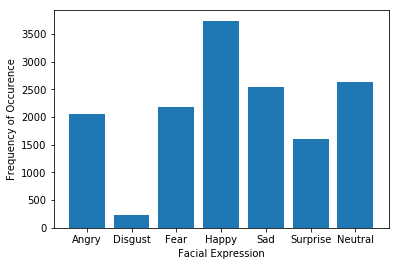

In [18]:
# seeing the distribution of each emotion in the dataset

frequency_list = np.zeros(7)

for label in labels:
    frequency_list[int(label)] += 1
    
emotion_indices = range(1,8)

x_axis_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise',
         'Neutral']


bar = plt.bar(emotion_indices, frequency_list, align='center')

plt.xticks(emotion_indices, x_axis_labels )

plt.xlabel("Facial Expression")

plt.ylabel("Frequency of Occurence")



plt.show()

In [19]:
train_tensors = df_to_tensor(X_train,48).astype('float32')/255
valid_tensors = df_to_tensor(X_val,48).astype('float32')/255
test_tensors = df_to_tensor(X_test,48).astype('float32')/255

train_targets = np.array(pd.get_dummies(y_train))
valid_targets = np.array(pd.get_dummies(y_val))
test_targets = np.array(pd.get_dummies(y_test))


In [20]:
img_width = 48
img_height = 48

### Evaluation Metrics

Due to the uneven distribution of facial expressions in the dataset, illustrated above, accuracy alone is not a suitable measure of classifier performance. Instead <b>categorical cross entropy loss</b> will be used to rank classifiers.


In [89]:
import numpy as np

# this function probably isn't needed, now that you are able to make use of keras' categorical cross entropy function which
# makes use of tensorflow

def my_categorical_cross_entropy(predictions_vector, targets_vector):
    #calculates, for each individual sample, the contribution to the total categorical cross entropy of the predictions with respect to the targets

    predictions = np.array(predictions_vector)

    targets = np.array(targets_vector)

    log_vector = -np.log(predictions_vector)

    return targets.dot(log_vector)
"""

predictions_ = [0.2, 0.3, 0.5]

targets_ = [0, 1, 0]


print categorical_cross_entropy(predictions_, targets_)

"""


'\n\npredictions_ = [0.2, 0.3, 0.5]\n\ntargets_ = [0, 1, 0]\n\n\nprint categorical_cross_entropy(predictions_, targets_)\n\n'

In [97]:
# function for getting model predictions of a CNN

#move this to higher up in the notebook later so you can use the same function for the other models

def get_model_predictions(input_model, input_test_tensors):
    return [input_model.predict(np.expand_dims(tensor, axis=0)) for tensor in input_test_tensors]

### Baseline Model

First, a simple CNN will be used to build a classifier, to which others can be compared. The baseline comprises only of two convolutional layers and a low amount of filters (ADD EXACT AMOUNT HERE AFTERWARD) and is expected to pick up basic features in the faces that will give it some degree of accuracy with the classification task


In [19]:
model_baseline = Sequential()
model_baseline.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(48,48,1)))
model_baseline.add(MaxPooling2D(pool_size=2))
model_baseline.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model_baseline.add(MaxPooling2D(pool_size=2))
model_baseline.add(Flatten())
model_baseline.add(Dense(100, activation='relu'))
#temporarily adding dropout
model_baseline.add(Dense(7, activation='softmax'))


model_baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 16)        80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        2080      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               460900    
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 707       
Total para

In [20]:
model_baseline.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# put repeated stuff into a function later on


### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.baseline.hdf5', 
                               verbose=1, save_best_only=True)

history = model_baseline.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 25120 samples, validate on 3589 samples
Epoch 1/20
25120/25120 [==============================] - 31s 1ms/step - loss: 1.6196 - acc: 0.3654 - val_loss: 1.4999 - val_acc: 0.4408
Epoch 2/20
25120/25120 [==============================] - 30s 1ms/step - loss: 1.4367 - acc: 0.4534 - val_loss: 1.4044 - val_acc: 0.4609
Epoch 3/20
25120/25120 [==============================] - 30s 1ms/step - loss: 1.3375 - acc: 0.4915 - val_loss: 1.3682 - val_acc: 0.4717
Epoch 4/20
25120/25120 [==============================] - 30s 1ms/step - loss: 1.2661 - acc: 0.5210 - val_loss: 1.3678 - val_acc: 0.4723
Epoch 5/20
25120/25120 [==============================] - 31s 1ms/step - loss: 1.1997 - acc: 0.5514 - val_loss: 1.3709 - val_acc: 0.4720
Epoch 6/20
25120/25120 [==============================] - 30s 1ms/step - loss: 1.1379 - acc: 0.5734 - val_loss: 1.3836 - val_acc: 0.4756
Epoch 7/20
25120/25120 [==============================] - 30s 1ms/step - loss: 1.0736 - acc: 0.6020 - val_loss: 1.4071 - val_acc:

In [22]:
model_baseline.load_weights('saved_models/weights.best.baseline.hdf5')

In [23]:
# get index of predicted facial expression for test set images
expression_predictions = [np.argmax(model_baseline.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(expression_predictions)==np.argmax(test_targets, axis=1))/len(expression_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.1889%


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


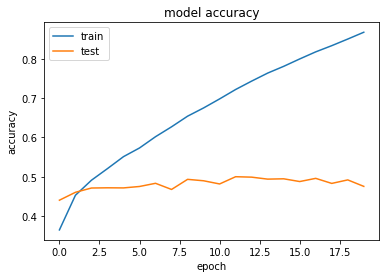

In [24]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Advanced Model

### Image Augmentation




In [26]:
from keras.preprocessing.image import ImageDataGenerator

def augment_data(train_tensors_input, valid_tensors_input, shift_width=0.1, shift_height=0.1, flip_hor=True,
                flip_vert=False):
    
    
    
    datagen_train = ImageDataGenerator(
        width_shift_range = shift_width,
        height_shift_range = shift_height,
        horizontal_flip = flip_hor,
        vertical_flip = flip_vert )

    # create and configure augmented image generator
    datagen_valid = ImageDataGenerator(
        width_shift_range = shift_width,
        height_shift_range = shift_height,
        horizontal_flip = flip_hor,
        vertical_flip = flip_vert )

    # fit augmented image generator on data
    datagen_train.fit(train_tensors_input)
    datagen_valid.fit(valid_tensors_input)
    
    return (datagen_train, datagen_valid)
    

In [27]:
(datagen_train, datagen_valid) = augment_data(train_tensors, valid_tensors)

In [13]:


model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                 input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       295168    
__________

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 20



### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_augmentation.hdf5', 
                               verbose=1, save_best_only=True)

"""
#Without image augmentation
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)
"""


#With image augmentation

batch_size = 20

history = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/20
1256/1256 [==============================] - 93s - loss: 1.7711 - acc: 0.2766 - val_loss: 1.6280 - val_acc: 0.3634
Epoch 2/20
1256/1256 [==============================] - 43s - loss: 1.5772 - acc: 0.3797 - val_loss: 1.4994 - val_acc: 0.4180
Epoch 3/20
1256/1256 [==============================] - 41s - loss: 1.4895 - acc: 0.4271 - val_loss: 1.4312 - val_acc: 0.4447
Epoch 4/20
1256/1256 [==============================] - 43s - loss: 1.4556 - acc: 0.4438 - val_loss: 1.3715 - val_acc: 0.4626
Epoch 5/20
 239/1256 [====>.........................] - ETA: 30s - loss: 1.4480 - acc: 0.4527

KeyboardInterrupt: 

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch_augmentation.hdf5')

In [17]:
# get index of predicted facial expression for test set images
expression_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(expression_predictions)==np.argmax(test_targets, axis=1))/len(expression_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.7880%


In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Transfer Learning

It is suitable to explore the use of other CNNs that have been used for other computer vision applications. Below, the performance of the pre-trained networks Inception, VGG-19 and Resnet50 will be explored

In [21]:
#import cv2

X_train_transf, X_test_transf, X_val_transf = X_train, X_test, X_val

y_train_transf, y_test_transf, y_val_transf = y_train, y_test, y_val


sample = df_to_tensor(X_train_transf, 48, reshape=False)

#sample.shape

In [22]:
# creating transfer tensors

train_tensors_transf = df_to_tensor(X_train_transf,48,reshape=False, triple_channels=True).astype('float32')/255
valid_tensors_transf = df_to_tensor(X_val_transf,48, reshape=False, triple_channels=True).astype('float32')/255
test_tensors_transf = df_to_tensor(X_test_transf,48, reshape=False, triple_channels=True).astype('float32')/255

train_targets_transf = np.array(pd.get_dummies(y_train_transf))
valid_targets_transf = np.array(pd.get_dummies(y_val_transf))
test_targets_transf = np.array(pd.get_dummies(y_test_transf))


In [23]:
# Note: the code below is an adaptation of a code snippet by Prakash Jay,
# obtained from: https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8

img_width, img_height = 48, 48
"""
train_data_dir = "data/train"
validation_data_dir = "data/val"
nb_train_samples = 4125
nb_validation_samples = 466 
"""
batch_size = 16
epochs = 50

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))


model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [24]:
# Image augmentation for transfer model

from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train_transf = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid_transf = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train_transf.fit(train_tensors_transf)
datagen_valid_transf.fit(valid_tensors_transf)

In [25]:
"""
for layer in model.layers:
    layer.trainable = False
"""

#allow training in initial layers for now, to see what the result is

'\nfor layer in model.layers:\n    layer.trainable = False\n'

In [26]:
# duplicate of prakash jay code
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
#two additional dense layers below with same dropout
#unsure whether it will help, go back to two if 
#needed
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

C:\Users\dhila\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.transfer_example_six.hdf5', 
                               verbose=1, save_best_only=True)

history = model_final.fit_generator(datagen_train_transf.flow(train_tensors_transf, train_targets_transf, batch_size=batch_size),
                    steps_per_epoch=train_tensors_transf.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid_transf.flow(valid_tensors_transf, valid_targets_transf, batch_size=batch_size),
                    validation_steps=valid_tensors_transf.shape[0] // batch_size)

In [27]:
model_final.load_weights('saved_models/weights.best.transfer_example_six.hdf5')

In [31]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['train', 'validation'], loc='upper left')
plt.title('Training and Validation data for VGG-19 transfer learning model')
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

#change to loss and val_loss to get categorical cross entropy plots!

NameError: name 'history' is not defined

In [28]:
# get index of predicted facial expression for test set images
expression_predictions_transf = [np.argmax(model_final.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors_transf]

# report test accuracy
test_accuracy = 100*np.sum(np.array(expression_predictions_transf)==np.argmax(test_targets_transf, axis=1))/len(expression_predictions_transf)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 70.4667%


In [93]:
raw_preds = [model_final.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors_transf]

raw_preds = get_model_predictions(model_final, test_tensors_transf)

In [94]:
print(raw_preds[1][0])

[ 0.11909138  0.01818695  0.19043124  0.02586892  0.13959607  0.08855235
  0.41827303]


In [95]:
print(test_targets_transf[0])

[0 0 0 1 0 0 0]


In [96]:
raw_preds_np = np.array(raw_preds,dtype='float32').reshape(3000,7)

print(raw_preds_np.shape[0])

print(test_targets_transf.shape)

total = 0

#TOBE a function
for i in range(raw_preds_np.shape[0]):
    if raw_preds_np.shape[0] != test_targets_transf.shape[0]:
        print("WRONG INPUT DIMS!")
        break
    total += my_categorical_cross_entropy(raw_preds_np[i], test_targets_transf[i])

print(total/raw_preds_np.shape[0])

#put this and the testing using the model into functions

3000
(3000, 7)
0.858913490727
